In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import yfinance as yf
import requests
from bs4 import BeautifulSoup

from arch import arch_model

import statistics as stat
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
dfData = yf.download("GLD VEU BTC-USD", start = "2020-01-01", end = "2020-12-31")
dfData = dfData.dropna()
dfData = dfData['Adj Close'][['BTC-USD', 'GLD', 'VEU']]
dfData.columns = ['BTC_Adj_Close', 'GLD_Adj_Close', 'VEU_Adj_Close']
#dfData.reset_index(inplace=True)
#dfData.set_index('Date', inplace=True)
dfData.head()

[*********************100%***********************]  3 of 3 completed


,BTC_Adj_Close,GLD_Adj_Close,VEU_Adj_Close
Date,,,
2019-12-31,7193.599121,142.899994,51.667725
2020-01-02,6985.470215,143.949997,52.330994
2020-01-03,7344.884277,145.860001,51.667725
2020-01-06,7769.219238,147.389999,51.763847
2020-01-07,8163.692383,147.970001,51.686951


In [3]:
dfData['GLD_Daily_Return'] = dfData['GLD_Adj_Close'] / dfData['GLD_Adj_Close'].shift(1) - 1
dfData['VEU_Daily_Return'] = dfData['VEU_Adj_Close'] / dfData['VEU_Adj_Close'].shift(1) - 1
dfData['BTC_Daily_Return'] = dfData['BTC_Adj_Close'] / dfData['BTC_Adj_Close'].shift(1) - 1# One day return
dfData.reset_index(inplace=True)
dfData.set_index('Date', inplace=True)
dfData['2020-04-01':'2020-12-31'].head()

,BTC_Adj_Close,GLD_Adj_Close,VEU_Adj_Close,GLD_Daily_Return,VEU_Daily_Return,BTC_Daily_Return
Date,,,,,,
2020-04-01,6606.776367,149.449997,37.880417,0.009456,-0.042418,0.026113
2020-04-02,6793.624512,151.899994,38.729061,0.016393,0.022403,0.028281
2020-04-03,6733.387207,152.649994,37.967209,0.004937,-0.019671,-0.008867
2020-04-06,7271.781250,156.880005,39.944164,0.027711,0.052070,0.079959
2020-04-07,7176.414551,156.039993,40.108112,-0.005354,0.004104,-0.013115


## Fitting a GARCH model

### We will be working with Bitcoin for fitting the GARCH model

In [16]:
dfData['BTC_MA_20D'] = dfData.rolling(window=20)['BTC_Adj_Close'].mean()

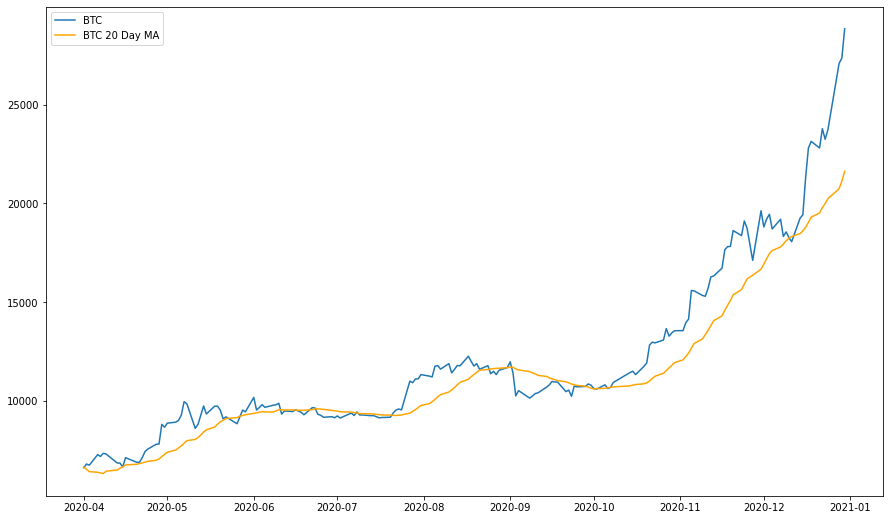

In [17]:
dfGraph = dfData.loc['2020-04-01':'2020-12-31']

plt.figure(figsize=(15,9))
plt.plot(dfGraph.index, dfGraph['BTC_Adj_Close'], label='BTC')
plt.plot(dfGraph.index, dfGraph['BTC_MA_20D'], label='BTC 20 Day MA', color='orange')
plt.legend(loc='upper left')
plt.show()

### Fitting a GARCH model for Q2, Q3 and Q4 (Bitcoin)

We will fit a GARCH(1,1) after we model the mean equation with an ARIMA(2,1,0).

In [21]:
dfb2q = dfData['BTC_Daily_Return']['2020-04-02':'2020-06-30'].diff() # 1st diff Q2
dfb3q = dfData['BTC_Daily_Return']['2020-07-01':'2020-09-30'].diff() # 1st diff Q3
dfb4q = dfData['BTC_Daily_Return']['2020-10-01':'2020-12-31'].diff() # 1st diff Q4

ADF Statistic: -7.834
p-value: 0.000000000
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


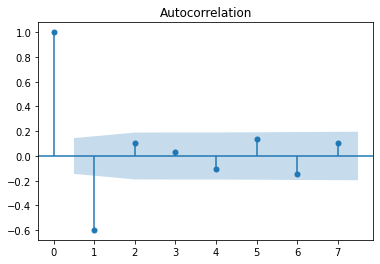

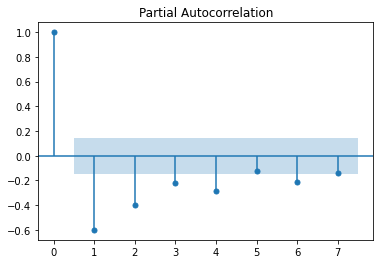

In [22]:
# for first difference:
gtest = dfData['BTC_Daily_Return']['2020-04-02':'2020-12-31'].diff().dropna()     

result = adfuller(gtest)
print('ADF Statistic: %.3f' % result[0])
print('p-value: %.9f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

plot_acf(gtest, lags=7)
plt.show()
plot_pacf(gtest, lags=7)
plt.show()

After checking the ACF and PACF we choose an ARIMA(2,1) on first differenced data

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
mod = ARIMA(dfb2q.dropna(), exog=None, order=(2,0,1))
res = mod.fit()
#print(res.summary())

mod2 = ARIMA(dfb3q.dropna(), exog=None, order=(2,0,1))
res2 = mod2.fit()
#print(res2.summary())

mod3 = ARIMA(dfb4q.dropna(), exog=None, order=(2,0,1))
res3 = mod3.fit()
#print(res3.summary())

**GARCH(1,1)**

 $ \sigma_t^2 = \omega + \alpha_1 \epsilon^2_{t-1} + \beta_1\sigma^2_{t-1}$

Conditional Variance =
    \begin{cases}
      \frac{\omega}{1-\alpha-\beta} & \text{weighted average of the long-run variance}\\
      \sigma^2_{t-1} & \text{the last predicted variance}\\
      \epsilon^2_{t-1} & \text{the new information }
    \end{cases}

**GARCH(1,1) for Bitcoin**

In [ ]:
dfb2q = dfData['BTC_Daily_Return']['2020-04-02':'2020-06-30'].diff() # 1st diff Q2
dfb3q = dfData['BTC_Daily_Return']['2020-07-01':'2020-09-30'].diff() # 1st diff Q3
dfb4q = dfData['BTC_Daily_Return']['2020-10-01':'2020-12-31'].diff() # 1st diff Q4

In [19]:
garch = arch_model(100*res.data.endog, vol='garch', p=1, o=0, q=0)
print('GARCH(1,1) for Bitcoin 2Q')
print(garch.fit().summary())
print()
garch2 = arch_model(100*res2.data.endog, vol='garch', p=1, o=0, q=1)
print('GARCH(1,1) for Bitcoin 3Q')**GARCH(1,1) for Bitcoin**
print(garch2.fit().summary())
print()
garch3 = arch_model(100*res3.data.endog, vol='garch', p=1, o=0, q=1)
print('GARCH(1,1) for Bitcoin 4Q')
print(garch3.fit().summary())
print()

GARCH(1,1) for Bitcoin 2Q
Iteration:      1,   Func. Count:      5,   Neg. LLF: 189.4687537964217
Iteration:      2,   Func. Count:     10,   Neg. LLF: 188.19800572441508
Iteration:      3,   Func. Count:     15,   Neg. LLF: 188.0979753006826
Iteration:      4,   Func. Count:     19,   Neg. LLF: 188.08529299221482
Iteration:      5,   Func. Count:     23,   Neg. LLF: 188.07691326975672
Iteration:      6,   Func. Count:     27,   Neg. LLF: 188.03658778877121
Iteration:      7,   Func. Count:     31,   Neg. LLF: 188.0043776580036
Iteration:      8,   Func. Count:     35,   Neg. LLF: 188.00280057078243
Iteration:      9,   Func. Count:     39,   Neg. LLF: 188.00274483247048
Iteration:     10,   Func. Count:     43,   Neg. LLF: 188.00274342252928
Iteration:     11,   Func. Count:     46,   Neg. LLF: 188.00274342252973
Optimization terminated successfully    (Exit mode 0)
            Current function value: 188.00274342252928
            Iterations: 11
            Function evaluations: 46
 

### Long-term variances indicated by the GARCH models

**GARCH**

Q2
* omega         15.8862      
* alpha[1]       0.6269 <br>
long term variance = omega/ 1-alpha-beta = 42.57


Q3
* omega         12.8375     
* alpha[1]       0.4028      
* beta[1]    2.5843e-16    <br>
long term variance = omega/ 1-alpha-beta = 21.49

Q4
* omega         14.3933     
* alpha[1]       0.7927      
* beta[1]        0.0000 <br>
long term variance = omega/ 1-alpha-beta = 69.4